In [3]:
import re
import sys
import math
import time
import json
import csv
import pickle
import random
import requests
import pprint
import numpy as np
import pandas as pd
import datetime as dt
import string
from itertools import combinations
from sklearn.metrics import cohen_kappa_score
from langdetect import detect
from datetime import datetime
from sklearn import metrics
import scipy.stats as stat
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from scipy.stats import chisquare, ttest_ind
from matplotlib.dates import DateFormatter
from collections import defaultdict, Counter

In [4]:
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)

In [5]:
data_root = '/home/haopeng/Data/Retraction/'
altmetric_start_date = datetime.strptime('2011-06-10', '%Y-%m-%d')
altmetric_end_date = datetime.strptime('2019-10-08', '%Y-%m-%d')
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}
day = 24*3600

In [6]:
blog_df = pd.read_csv(data_root + 'blog_mentions_correction.csv', header = 0)
blog_set = set(blog_df.loc[~blog_df.maybe_news.isnull(), 'blog_name'])

def correct_blogs(data, error_blogs):
    for xid, paper in data.items():
        if 'blogs' in paper['posts']:
            blogs_li = paper['posts']['blogs']
            news_li = []
            if 'news' in paper['posts']:
                news_li = paper['posts']['news']
            blogs_li_new = []
            for item in blogs_li:
                try:
                    if item['author']['name'] in error_blogs:
                        news_li.append(item)
                    else:
                        blogs_li_new.append(item)
                except:
                    pass
            paper['posts']['news'] = news_li
            paper['posts']['blogs'] = blogs_li_new
    return data

### Load tweets for retracted and control papers

In [9]:
tid_date = {}
tid_text = {}
tid_author = {}
tid_follow_cn = {}
retweet_org_ids = {}

with open(data_root+'tweets.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        tid, tdate = line['id_str'], line['created_at']
        user_name = line['user']['screen_name']
        re_status = False
        text = ""
        try:
            text = line['retweeted_status']['full_text']
            org_tid = line['retweeted_status']['id_str']
            re_status = True
        except:  # Not a Retweet
            text = line['full_text']
        try:
            # only use English tweets
            # this gives error if text only contains url.
            if detect(text) == 'en':
                tid_date[tid] = datetime.strptime(tdate, '%a %b %d %H:%M:%S +0000 %Y')
                tid_text[tid] = text
                tid_author[tid] = user_name
                tid_follow_cn[tid] = int(line['user']['followers_count'])
                if re_status:
                    retweet_org_ids[tid] = org_tid
        except:
            pass

In [53]:
len(tid_text)

159408

In [54]:
len(tid_author)

159408

In [55]:
len(tid_date)

159408

In [56]:
len(retweet_org_ids)

87670

In [21]:
cn = 0
for tid, text in tid_text.items():
    if text[-1:] == "…":
        cn += 1
# frac of trancated tweets
print(cn/len(tid_text))

0.0019384221619993978


In [15]:
with open(data_root + 'tweets_processed.pickle', 'wb') as ofile:
    pickle.dump([tid_date, tid_text, tid_author, tid_follow_cn, retweet_org_ids], ofile)

In [46]:
with open(data_root + 'tweets_processed.pickle', 'rb') as ofile:
    tid_date, tid_text, tid_author, tid_follow_cn, retweet_org_ids = pickle.load(ofile)

### Load Alt data

In [8]:
doi_alt_data = {}

with open(data_root+"retraction_altmetric.json", 'r') as ffile:
    for row in ffile:
        record = json.loads(row)
        doi = record['citation']['doi'].lower()
        doi_alt_data[doi] = record

doi_alt_data = correct_blogs(doi_alt_data, blog_set)

In [9]:
len(doi_alt_data)

6838

In [10]:
doi_control_aids ={}

with open(data_root+"doi_control_alt_ids.json", 'r') as ffile:
    for line in ffile:
        line = json.loads(line)
        doi_control_aids[line['doi']] = [str(x) for x in line['alt_ids']]

In [11]:
with open(data_root+'df_retract_clean.pickle', 'rb') as file:
    retract_df = pickle.load(file)

In [12]:
len(retract_df)

6680

Exclude retracted papers published before Altmetric start date

In [13]:
retract_df = retract_df.loc[retract_df.pub_date_corrected.apply(lambda dttt: (dttt-altmetric_start_date).total_seconds() > 0)]
retract_df.index = range(len(retract_df))

In [14]:
retract_df = retract_df.loc[retract_df.OriginalPaperDOI.isin(doi_control_aids)]
retract_df.index = range(len(retract_df))

In [15]:
len(retract_df)

3985

In [16]:
doi_ret_date = dict(zip(retract_df['OriginalPaperDOI'], retract_df['RetractionDate']))

In [18]:
altid_data = {}

with open(data_root+"control_alt_papers.json", 'r') as ffile:
    for row in ffile:
        paper = json.loads(row)
        altid = str(paper['altmetric_id'])
        altid_data[altid] = paper
        
altid_data = correct_blogs(altid_data, blog_set)

In [17]:
control_aid_doi = {}

for doi in retract_df.OriginalPaperDOI:
    for aid in doi_control_aids[doi]:
        control_aid_doi[aid] = doi

In [1]:
len(control_aid_doi)

19925


### Check issue of retraction date (already done and used in `3_create_retract_dataframe.ipynb`)

In [527]:
cand_tids_ret = dict()
cand_tids_control = dict()

for doi, ret_date in doi_ret_date.items():
    paper = doi_alt_data[doi]
    cand_tids_ret[doi] = []
    if 'posts' in paper and 'twitter' in paper['posts']:
        for item in paper['posts']['twitter']:
            tid = item['tweet_id']
            # exclude retweets
            if tid in tid_date and tid not in retweet_org_ids:
                dttt = tid_date[tid]
                if (ret_date - dttt).total_seconds() > 0:
                    cand_tids_ret[doi].append(tid)
                    
for altid, matched_doi in control_aid_doi.items():
    ret_date = doi_ret_date[matched_doi]
    paper = altid_data[altid]
    cand_tids_control[altid] = []
    if 'posts' in paper and 'twitter' in paper['posts']:
        for item in paper['posts']['twitter']:
            tid = item['tweet_id']
            if tid in tid_date and tid not in retweet_org_ids:
                dttt = tid_date[tid]
                if (ret_date - dttt).total_seconds() > 0:
                    cand_tids_control[altid].append(tid)

In [528]:
cn = 0
for doi, tids in cand_tids_ret.items():
    if len(tids) > 0:
        cn += 1

In [529]:
cn

1841

In [245]:
tids_ = set()
for doi, tids in cand_tids_ret.items():
    for tid in tids:
        if tid_author[tid] == "SciBlotter":
            tids_.add(tid)
        else:
            if 'retract' in tid_text[tid].lower():
                tids_.add(tid)
                print(tid, ':', tid_author[tid])
                print(tid_text[tid])
                print()            

1151175435486662657 : DanGraur
@MicrobiomDigest For this s**t, Subha Sen, then at @ClevelandClinic and now whereabouts unknown, received at least $3,261,686 from @NIH. Sudhiranjan Gupta is currently an assistant professor at @TAMUmedicine. 
https://t.co/Lk9JdUneks
https://t.co/TZsVIRCBbU @RetractionWatch https://t.co/Y3SpmHdcnT

1030879562132086784 : SanLi_today
A 2006 @nature paper is suspected for figure fraud: https://t.co/SyKYZmXByJ - if this gets retracted- the review by the same authors is also compromised substatially 
DOI 10.1158/0008-5472.CAN-06-3197
@schneiderleonid @AACR

1089975862064308225 : fxcoudert
@PubPeer @RetractionWatch @DaltonTrans @RSC_Adv And, at the very least, some unacknowledged figure sharing here, between @RSC_Adv and Photochemical &amp; Photobiological Sciences

https://t.co/kR8v6a7MAA
https://t.co/qb6uhgPiIZ https://t.co/9qcU8WLD0m

1089971196093972480 : fxcoudert
@PubPeer @RetractionWatch Want to make you look at these authors' other papers right? Well, h

In [1388]:
len(tids_)

572

In [1184]:
tweets_ = pd.DataFrame(tids_, columns=['tid'])
tweets_['user_name'] = tweets_.tid.map(tid_author)
tweets_['text'] = tweets_.tid.map(tid_text)
tweets_['is_retraction_notice'] = 0
tweets_.to_csv(data_root+'label_retract_tweets_date_correction.csv', header=True, index=False)

In [211]:
tweets_ = pd.read_csv(data_root+'label_retract_tweets_date_correction.csv', header=0, dtype={'tid': 'str'})

In [214]:
tids_ = set(tweets_.tid)
tids_r = set(tweets_.loc[tweets_.is_retraction_notice == 1, 'tid'])

In [248]:
len(tids_r)

469

In [249]:
gaps = []
for doi, tids in cand_tids_ret.items():
    li = []
    for tid in tids:
        if tid in tids_r:
            t_off = (doi_ret_date[doi] - tid_date[tid]).total_seconds()
            li.append((tid, t_off))
    if len(li) > 0:
        tid, should_be_earlier_at_least = sorted(li, key=lambda x: x[1], reverse=True)[0]
        day_off = should_be_earlier_at_least//day
        gaps.append((doi, tid, day_off))

In [250]:
len(gaps)

366

In [251]:
gaps = pd.DataFrame(gaps, columns=['doi', 'tid', 'gap_in_days'])
gaps = gaps.merge(retract_df[['Title', 'Journal', 'pub_date_corrected', 'RetractionDate', 'OriginalPaperDOI']], left_on='doi', right_on='OriginalPaperDOI')
gaps['tweet_text'] = gaps.tid.map(tid_text)
gaps['tweet_date'] = gaps.tid.map(tid_date)
gaps['tweet_user'] = gaps.tid.map(tid_author)

In [252]:
gaps.head()

,doi,tid,gap_in_days,Title,Journal,pub_date_corrected,RetractionDate,OriginalPaperDOI,tweet_text,tweet_date,tweet_user
0,10.1016/j.jpowsour.2014.05.006,1091481797760823296,467.0,The use of well-aligned composite nanorod arra...,Journal of Power Sources,2014-05-14 00:00:00,2020-05-14 00:00:00,10.1016/j.jpowsour.2014.05.006,"Journal of Power Sources\n""RETRACTED: The use ...",2019-02-01 23:41:53,SciBlotter
1,10.1080/10790268.2017.1420537,993936102754004993,734.0,Three-Minutes Sitting Test for evaluating lumb...,Journal of Spinal Cord Medicine,2018-01-11 00:00:00,2020-05-12 00:00:00,10.1080/10790268.2017.1420537,"The Journal of Spinal Cord Medicine\n""RETRACTE...",2018-05-08 19:30:07,SciBlotter
2,10.1007/s12648-014-0535-1,911986950910939136,922.0,Studies on long lasting optical properties of ...,Indian Journal of Physics,2014-06-26 00:00:00,2020-04-04 00:00:00,10.1007/s12648-014-0535-1,"Indian Journal of Physics\n""RETRACTED ARTICLE:...",2017-09-24 16:13:27,SciBlotter
3,10.1016/j.wear.2009.06.034,1125863479821389824,326.0,Dry sliding wear behaviour of cast high streng...,Wear,2009-06-26 00:00:00,2020-03-29 00:00:00,10.1016/j.wear.2009.06.034,"Wear\n""RETRACTED: Dry sliding wear behaviour o...",2019-05-07 20:42:25,SciBlotter
4,10.1007/s11042-017-5403-5,1129804226253742081,302.0,Cross-camera multi-person tracking by leveragi...,Journal of Visual Communication and Image Repr...,2018-01-02 00:00:00,2020-03-16 00:00:00,10.1007/s11042-017-5403-5,"Multimedia Tools and Applications\n""RETRACTED ...",2019-05-18 17:41:32,SciBlotter


In [1628]:
len(gaps.loc[gaps.tweet_user == 'SciBlotter'])

314

In [ ]:
# this paper has correct ret date in RW.
gaps = gaps.loc[gaps.doi != '10.1371/journal.pone.0146193']

In [1629]:
gaps.to_csv(data_root+'dois_correct_retract_date.csv', header=True, index=False, \
            columns=['doi', 'Title', 'Journal', 'pub_date_corrected', 'RetractionDate', \
                     'tid', 'tweet_user', 'tweet_text', 'tweet_date', 'gap_in_days'])

In [1243]:
gaps = pd.read_csv(data_root+'dois_correct_retract_date.csv', header=0, dtype={'tid': 'str'})

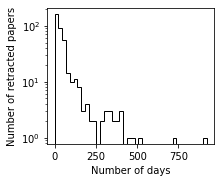

In [1244]:
a = 1
b = 40
fig, ax1 = plt.subplots(1, 1, figsize=(3, 2.5))
ax1.hist(gaps.gap_in_days, bins = b, alpha = a, color = 'black', histtype='step')

ax1.set_ylabel('Number of retracted papers')
ax1.set_xlabel('Number of days')
ax1.set_yscale('log')
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
plt.show()

In [1630]:
np.median(gaps.gap_in_days)

29.0

Check a random sample of retracted paper for the retraction date

In [1522]:
retract_df.loc[~retract_df['OriginalPaperDOI'].isin(gaps.doi)][['OriginalPaperDOI', 'RetractionDOI', 'RetractionDate']].sample(n=10, random_state=10)

,OriginalPaperDOI,RetractionDOI,RetractionDate
6513,10.1046/j.1528-1157.2003.05203.x,10.1046/j.1528-1157.2003.44114_1.x,2003-10-29 00:00:00
918,10.1097/inf.0000000000002277,10.1097/INF.0000000000002331,2019-03-19 00:00:00
4058,10.1007/s11033-014-3731-3,10.1007/s11033-015-3873-y,2015-04-08 00:00:00
48,10.1186/1029-242x-2014-497,10.1186/s13660-020-02399-5,2020-04-28 00:00:00
353,10.3389/fnins.2018.00529,10.3389/fnins.2019.01265,2019-11-20 00:00:00
1769,10.1107/s2059798317015303,10.1107/S2059798318004047,2018-04-01 00:00:00
2163,10.1089/dna.2017.3798,10.1089/dna.2017.3798.retract,2017-09-22 00:00:00
6296,10.1016/j.jchromb.2006.04.040,10.1016/j.jchromb.2008.02.001,2008-02-09 00:00:00
100,10.1158/1078-0432.ccr-15-2158,10.1158/1078-0432.CCR-20-0653,2020-04-01 00:00:00
778,10.1080/17430437.2013.791488,10.1080/17430437.2019.1603685,2019-05-09 00:00:00


- 918: https://journals.lww.com/pidj/Fulltext/2019/04000/Clinical_Course_and_Management_of_Dengue_in.27.aspx
- 2163: https://www.liebertpub.com/doi/10.1089/dna.2017.3798.retract
- 6296: https://www.sciencedirect.com/science/article/pii/S1570023208001025

Correct retraction date (retract_df is already corrected, skip now)

In [253]:
gaps = pd.read_csv(data_root+'dois_correct_retract_date.csv', header=0, dtype={'tid': 'str'})
doi_ret_update = dict(zip(gaps.doi, gaps.tweet_date))

In [530]:
len(doi_ret_update)

381

In [531]:
for doi, dstr in doi_ret_update.items():
    retract_df.loc[retract_df['OriginalPaperDOI'] == doi, 'RetractionDate'] = datetime.strptime(dstr, '%Y-%m-%d %H:%M:%S')
    

In [532]:
doi_ret_date = dict(zip(retract_df['OriginalPaperDOI'], retract_df['RetractionDate']))

### Get tweets prior retraction (after correcting retraction date)

In [25]:
cand_tids_ret = dict()
cand_tids_control = dict()

for doi, ret_date in doi_ret_date.items():
    paper = doi_alt_data[doi]
    cand_tids_ret[doi] = []
    if 'posts' in paper and 'twitter' in paper['posts']:
        for item in paper['posts']['twitter']:
            tid = item['tweet_id']
            # exclude retweets
            if tid in tid_date and tid not in retweet_org_ids:
                dttt = tid_date[tid]
                if (ret_date - dttt).total_seconds() > 0:
                    cand_tids_ret[doi].append(tid)
                    
for altid, matched_doi in control_aid_doi.items():
    ret_date = doi_ret_date[matched_doi]
    paper = altid_data[altid]
    cand_tids_control[altid] = []
    if 'posts' in paper and 'twitter' in paper['posts']:
        for item in paper['posts']['twitter']:
            tid = item['tweet_id']
            if tid in tid_date and tid not in retweet_org_ids:
                dttt = tid_date[tid]
                if (ret_date - dttt).total_seconds() > 0:
                    cand_tids_control[altid].append(tid)

In [86]:
len(cand_tids_ret)

3985

In [88]:
len(cand_tids_control)

19925

In [87]:
sum([len(v) for v in cand_tids_ret.values()])

16212

In [89]:
sum([len(v) for v in cand_tids_control.values()])

33276

### Label uncertain tweets

In [1016]:
sample_tw = pd.DataFrame(random.sample(tid_words_rm_ti_ab.keys(), k=1000), columns=['tid'])
sample_tw['text'] = sample_tw.tid.map(tid_text)

In [1018]:
sample_tw.to_csv(data_root+'sample_tw_1k.csv', header=True, index=False)

In [1421]:
sample_tw = pd.read_csv(data_root+'sample_tw_1k_new.csv', header=0, dtype={'tid': str})

In [1422]:
sample_tw = sample_tw.loc[sample_tw.tid.isin(tid_words_rm_ti_ab)]

In [1423]:
sample_tw.loc[sample_tw.is_uncertain.isnull(), 'is_uncertain'] = 0

In [1424]:
np.sum(sample_tw.is_uncertain)

30.0

In [48]:
word_li = set()
with open(data_root+'doubt_words.txt', 'r') as ifile:
    for line in ifile:
        w = line.strip()
        if w not in word_li:
            word_li.add(w)
        else:
            print(w)
            
# distrust, disbelief, doubt, concern, question, confusion, suspicion, credibility, uncertain, unsure, criticism
def is_doubt(text):
    text = text.lower()
    for w in word_li:
        if w in text:
            return 1
    return 0

In [49]:
len(word_li)

76

In [1425]:
y_true = sample_tw.is_uncertain.tolist()
y_pred = []
for tid, text in zip(sample_tw.tid, sample_tw.text):
    y_pred.append(is_doubt(text))
confux = metrics.confusion_matrix(y_true, y_pred)
report = metrics.classification_report(y_true, y_pred)

In [1426]:
print('\nConfusion matrix:\n\n{}'.format(confux))


Confusion matrix:

[[765 175]
 [  3  27]]


In [1427]:
print('\nReport:\n\n{}'.format(report))


Report:

              precision    recall  f1-score   support

         0.0       1.00      0.81      0.90       940
         1.0       0.13      0.90      0.23        30

    accuracy                           0.82       970
   macro avg       0.56      0.86      0.56       970
weighted avg       0.97      0.82      0.88       970



In [1429]:
pos_df = sample_tw.loc[sample_tw.is_uncertain==1]

signal_words = []
for text in pos_df.text:
    text = text.lower()
    for w in word_li:
        if w in text:
            signal_words.append(w)
            break
    else:
        signal_words.append('')
        
pos_df['signal_word'] = signal_words

In [1430]:
pd.set_option('display.max_colwidth', 500)
pos_df

,tid,text,is_uncertain,signal_word
29,345149232556154881,". @mjhsinclair Adam citing this paper http://t.co/8tuo06zDlE to climate comms conference, see Retraction Watch on.http://t.co/sgYoHiaiXq",1.0,retract
46,908485178187829253,good lord.....surely this is a joke? @thirdworldq https://t.co/d5RyM1KODD,1.0,?
65,1123641939411312640,"@BioMedCentral, can you explain why this article (https://t.co/9U0e0NUk3u) is still up with nothing more than an ""Editor's Note"" that concerns have been raised nearly a year after @cbpolis' letter of concern was published (notably, with resounding positive reviews for her letter)",1.0,concern
95,131414419338051586,"The journal Science has an ""editorial expression of concern"" regarding alleged scientific fraud in this report: http://t.co/ivox2svE",1.0,concern
127,907928786934607872,"*Checks calendar* Okay, it's not April fools day so... whaaaat? https://t.co/wv3IC3vEr3",1.0,?
130,1139159646919434242,"@HeyRoo1 @Kappa_Kappa I’m sure you know that’s not how it works, nor is it my position. My position is simple. But here is a study the raises concerns about the HPV vaccine: https://t.co/Bxl84XcBKJ",1.0,concern
134,1124335688634327053,"Ok, but how can we believe the CDC when they admitted they lied about suicides, hiding the numbers in with overdoses over this entire decade. What about suboxone deaths? Also CDC reported Kratom deaths, not even possible, CDC lost credibility, sorry https://t.co/vK7BGaYoFY",1.0,?
150,1038215506682105862,"Astonishing that this is just starting to gain traction. Yes, burnout or overall dissatisfaction/resentment at work IS a #ptsafety issue. How can we give our best to patients when we are chronically unsupported by our systems? https://t.co/c5q6NlLv62",1.0,?
154,652254739258716160,This makes me never want to publish in @PLOSONE again. http://t.co/0hl9tSa7r6,1.0,publish
169,1177596223815069697,How do you counter Gynos saying that these ppl might have stds that is why they have lower probability of getting pregnant??? https://t.co/WEYGpFWqYZ,1.0,?


In [1431]:
pos_df.to_csv(data_root+'pos_tweets.csv', header=True, index=False)

Manually label all tweets that meet the heuristic

In [540]:
cand_tids = set()

cn = 0
for doi, tids in cand_tids_ret.items():
    for tid in tids:
        if is_doubt(tid_text[tid]):
            cand_tids.add(tid)
            cn += 1
for altid, tids in cand_tids_control.items():
    for tid in tids:
        if is_doubt(tid_text[tid]):
            cand_tids.add(tid)

In [541]:
cn

3655

In [542]:
len(cand_tids)

9341

In [1436]:
cand_tweets_df = pd.DataFrame(cand_tids, columns=['tid'])
cand_tweets_df['text'] = cand_tweets_df.tid.map(tid_text)
cand_tweets_df['is_uncertain'] = ''
cand_tweets_df['note'] = ''

In [1437]:
signal_words = []
for text in cand_tweets_df.text:
    text = text.lower()
    for w in word_li:
        if w in text:
            signal_words.append(w)
            break
    else:
        signal_words.append('')

cand_tweets_df['signal_word'] = signal_words

In [1438]:
cand_tweets_df.head(100)

,tid,text,is_uncertain,note,signal_word
0,705409152844038144,"Perfect #steel casting is impossible, so which #defects are okay and which ones are problems? https://t.co/imKHWVnZXs",,,problem
1,903646029253312513,@fakejokename @BamaWriter @absurdistwords https://t.co/12zrnZ2RCR,,,fake
2,1179471189590368259,"International Case-Control #STUDY: History of #CHICKENPOX in GLIOMA Risk\n\nhttps://t.co/tLFv4L86cd\n\n""A positive history of chickenpox was associated w/ a 21% LOWER glioma risk. Furthermore, the protective effect of chickenpox was stronger for high-grade gliomas.""\n\n#cancer https://t.co/8VlVuFbRt0",,,story
3,1180892237468753920,@PoliSciJack Agree &amp; have been developing models for the variance with applications such as this one. Not yet applied to political behaviour but think it likely a fruitful avenue. https://t.co/xczSgEt2GD,,,lie
4,831221406180388864,Manifesto For Reproducible Science - a must read for all academics &amp; researchers: https://t.co/Rg0em3Fp4s https://t.co/RTsRAVxfhd,,,academic
5,907947906224742400,Ugh. How did this get past #peerreview?! #PeerRevWk17 https://t.co/IYKJ4eKEvo,,,?
6,248463550887112705,"RT @michaelpollan: Long-term feeding study of GM crops and Round-Up, finds serious health problems in rats http://t.co/dopiyuXf",,,problem
7,1136349657670381568,Going to discuss the exciting research from @GoogleAI in #LungCancer detection with #DeepLearning at our upcoming journal club.\nRead more here: https://t.co/emxAycRLTV\n\n#ArtificialIntelligence #ComputerVision #MedicalImaging #CT #LungCancerScreening #datascience #neuralnetwork,,,data
8,1060222915776401408,ocean warming is at the high end of prior estimates... translation: nothing matters and we’re all gonna die lol https://t.co/v25B31XOXA,,,lol
9,637213553527816192,@WorldLungFdn Stopping CoalFlyAsh #GeoEngineering would improve lung health? http://t.co/B4zvI2kErl http://t.co/C2uh66XNMj,,,?


In [1502]:
cand_tweets_df.to_csv(data_root+'cand_uncertain_tweets.csv', quoting=csv.QUOTE_ALL, header=True, index=False)

Agreement (first 500 tweets)

In [1561]:
rs = []
for name in ['annika', 'berit', 'nicole']:
    r1 = pd.read_csv(data_root+'cand_uncertain_tweets_%s.csv'%name, quoting=csv.QUOTE_ALL)
    r1 = r1.loc[:499, ['tid', 'text', 'is_uncertain']]
    r1 = r1.replace({np.NaN: 0})
    r1.loc[r1.text.apply(lambda x: x[:15] == 'True or false? '), 'is_uncertain'] = 1
    rs.append(r1)

In [1562]:
rs[0]

,tid,text,is_uncertain
0,705409152844038144,"Perfect #steel casting is impossible, so which #defects are okay and which ones are problems? https://t.co/imKHWVnZXs",0.0
1,903646029253312513,@fakejokename @BamaWriter @absurdistwords https://t.co/12zrnZ2RCR,0.0
2,1179471189590368259,"International Case-Control #STUDY: History of #CHICKENPOX in GLIOMA Risk\n\nhttps://t.co/tLFv4L86cd\n\n""A positive history of chickenpox was associated w/ a 21% LOWER glioma risk. Furthermore, the protective effect of chickenpox was stronger for high-grade gliomas.""\n\n#cancer https://t.co/8VlVuFbRt0",0.0
3,1180892237468753920,@PoliSciJack Agree &amp; have been developing models for the variance with applications such as this one. Not yet applied to political behaviour but think it likely a fruitful avenue. https://t.co/xczSgEt2GD,0.0
4,831221406180388864,Manifesto For Reproducible Science - a must read for all academics &amp; researchers: https://t.co/Rg0em3Fp4s https://t.co/RTsRAVxfhd,0.0
5,907947906224742400,Ugh. How did this get past #peerreview?! #PeerRevWk17 https://t.co/IYKJ4eKEvo,1.0
6,248463550887112705,"RT @michaelpollan: Long-term feeding study of GM crops and Round-Up, finds serious health problems in rats http://t.co/dopiyuXf",0.0
7,1136349657670381568,Going to discuss the exciting research from @GoogleAI in #LungCancer detection with #DeepLearning at our upcoming journal club.\nRead more here: https://t.co/emxAycRLTV\n\n#ArtificialIntelligence #ComputerVision #MedicalImaging #CT #LungCancerScreening #datascience #neuralnetwork,0.0
8,1060222915776401408,ocean warming is at the high end of prior estimates... translation: nothing matters and we’re all gonna die lol https://t.co/v25B31XOXA,0.0
9,637213553527816192,@WorldLungFdn Stopping CoalFlyAsh #GeoEngineering would improve lung health? http://t.co/B4zvI2kErl http://t.co/C2uh66XNMj,1.0


In [1563]:
ks = []
for r1, r2 in combinations(rs, r=2):
    kappa = cohen_kappa_score(r1['is_uncertain'], r2['is_uncertain'])
    ks.append(kappa)
    print(kappa)

0.6415697198099295
0.6575571294935186
0.6133173504504852


Agreement (second 500 tweets)

In [122]:
rs = {}
names = ['hao', 'annika', 'berit', 'nicole']
for name in names:
    r1 = pd.read_csv(data_root+'cand_uncertain_tweets_%s.csv'%name, quoting=csv.QUOTE_ALL)
    r1 = r1.loc[500:999, ['tid', 'text', 'is_uncertain']]
    r1 = r1.replace({np.NaN: 0})
    rs[name] = r1

In [123]:
ks = []
for n1, n2 in combinations(names, r=2):
    r1 = rs[n1]
    r2 = rs[n2]
    kappa = cohen_kappa_score(r1['is_uncertain'], r2['is_uncertain'])
    ks.append(kappa)
    print(n1, n2, kappa)

hao annika 0.823259102156239
hao berit 0.7834946510443199
hao nicole 0.7231357809248943
annika berit 0.7136907860489329
annika nicole 0.7291724909141739
berit nicole 0.5776059564719358


In [1680]:
np.sum(np.array(rs['annika']['is_uncertain'] + rs['berit']['is_uncertain'] + rs['nicole']['is_uncertain']) == 1)

44

In [1681]:
np.sum(np.array(rs['annika']['is_uncertain'] + rs['berit']['is_uncertain'] + rs['nicole']['is_uncertain']) == 2)

30

Agreement (all tweets)

In [41]:
hao_df = pd.read_csv(data_root+'cand_uncertain_tweets_hao.csv', quoting=csv.QUOTE_ALL, dtype={'tid': str})

In [42]:
len(hao_df)

9817

In [43]:
tids_exclude = hao_df.loc[hao_df.is_retraction_notification == 1, 'tid'].tolist()

In [44]:
len(tids_exclude)

28

In [45]:
rs = {}
names = ['hao', 'annika', 'berit']
for name in names:
    r1 = pd.read_csv(data_root+'cand_uncertain_tweets_%s.csv'%name, quoting=csv.QUOTE_ALL, dtype={'tid': str})
    # remove ret notification posts
    r1 = r1.loc[~r1.tid.isin(tids_exclude), ['tid', 'text', 'is_uncertain']]
    r1.loc[r1.text.apply(lambda x: 'True or false?' in x), 'is_uncertain'] = 1
    r1 = r1.replace({np.NaN: 0})
    rs[name] = r1

In [374]:
ks = []
for n1, n2 in combinations(names, r=2):
    r1 = rs[n1]
    r2 = rs[n2]
    kappa = cohen_kappa_score(r1['is_uncertain'], r2['is_uncertain'])
    ks.append(kappa)
    print(n1, n2, kappa)

hao annika 0.7452971539309748
hao berit 0.6307474210718712
annika berit 0.6294304116767713


Combine

In [46]:
votes = np.array([rs[name]['is_uncertain'].values for name in names]).T
votes = np.sum(votes, axis=1)

In [47]:
np.unique(votes, return_counts=True)

(array([0., 1., 2., 3.]), array([7585,  888,  389,  927]))

In [48]:
tid_votes = dict(zip(rs['hao'].tid, votes))

In [49]:
len(tid_votes)

9789

In [380]:
bad_ix = (votes == 1) | (votes == 2)

In [381]:
bad_df = rs['hao'].loc[bad_ix, ['tid', 'text']]
bad_df = bad_df.sample(frac = 1.0, random_state=10)
bad_df.index = range(len(bad_df))

In [382]:
len(bad_df)

1277

In [286]:
bad_df.to_csv(data_root+'cand_uncertain_tweets_disagree.csv', quoting=csv.QUOTE_ALL, header=True, index=False)

In [65]:
agnes = pd.read_csv(data_root+'cand_uncertain_tweets_disagree_agnes.csv', quoting=csv.QUOTE_ALL, dtype={'tid': str})

In [66]:
len(agnes)

640

In [67]:
agnes.loc[agnes.is_uncertain != 1, 'is_uncertain'] = 0

In [436]:
agnes['votes'] = agnes.tid.map(tid_votes)

In [437]:
agnes['new_votes'] = agnes.apply(lambda row: row['is_uncertain'] + row['votes'], axis = 1)

In [438]:
agnes.loc[agnes.new_votes == 2]

,tid,text,is_uncertain,note,votes,new_votes
1,1160236702746710017,Paper shows that either the #HPVvaccine causes...,1.0,very subtle case of skepticism,1.0,2.0
4,826777540555657217,What is the mechanism of #Ketamine's rapid-ons...,1.0,NaN,1.0,2.0
5,137613641980706816,Fundamental fallacy: data per se may be object...,1.0,NaN,1.0,2.0
6,869698761257349120,Still not losing sleep over genetic manipulati...,1.0,NaN,1.0,2.0
8,306820792455401472,"Yes @rmahenry, but... was the study's oil real...",1.0,NaN,1.0,2.0
...,...,...,...,...,...,...
623,662988793604153346,"Dear fellow scientist, visionaries, future lea...",0.0,NaN,2.0,2.0
625,989677289850982400,What does that 1 in 59 mean? Source from US CD...,1.0,NaN,1.0,2.0
632,493103451212357632,"Hey, @drpaulmorgan, seen what @BrownBagPantry ...",1.0,NaN,1.0,2.0
633,909205446153474048,Absense of #history in #politicalscience @thir...,1.0,NaN,1.0,2.0


In [439]:
agnes.new_votes.value_counts()

2.0    353
3.0    150
1.0    137
Name: new_votes, dtype: int64

In [479]:
tid_mvotes = tid_votes.copy()

In [480]:
for tid, mvote in tid_mvotes.items():
    if mvote == 3:
        tid_mvotes[tid] = 1

In [481]:
for tid, nvote in zip(agnes.tid, agnes.new_votes):
    if nvote == 1:
        tid_mvotes[tid] = 0
    elif nvote == 3:
        tid_mvotes[tid] = 1
    else:
        del tid_mvotes[tid]

In [69]:
daniel = pd.read_csv(data_root+'cand_uncertain_tweets_disagree_daniel.csv', quoting=csv.QUOTE_ALL, dtype={'tid': str})

In [70]:
len(daniel)

637

In [444]:
daniel['votes'] = daniel.tid.map(tid_votes)

In [445]:
daniel['new_votes'] = daniel.apply(lambda row: row['is_uncertain'] + row['votes'], axis = 1)

In [446]:
daniel.loc[daniel.new_votes == 2]

,tid,text,is_uncertain,votes,new_votes
2,917167740821102592,MicroRNA-371-5p targets SOX2 in gastric cancer...,1,1.0,2.0
3,753943704973574146,https://t.co/SVLViK2NkT worth to learn some pr...,0,2.0,2.0
4,874708043044446209,"Have yet to confirm this myself, but it does r...",0,2.0,2.0
6,1133358832011415552,@AbuLiyana1 @Oldgringo12 @akkitwts Propaganda ...,0,2.0,2.0
7,907660542487273472,All this thread. Plus Gilley's analysis uncrit...,1,1.0,2.0
...,...,...,...,...,...
621,153501286778679296,Mud sticks: Mendel exonerated years ago of the...,1,1.0,2.0
626,893524442231357440,But what/where/when did those sequenced sample...,1,1.0,2.0
628,341606658650300416,"""How the polls can be both spot on and dead wr...",0,2.0,2.0
629,1018917587391012869,Well then. I think I feel better about myself....,1,1.0,2.0


In [483]:
daniel.new_votes.value_counts()

1.0    320
2.0    191
3.0    126
Name: new_votes, dtype: int64

In [484]:
for tid, nvote in zip(daniel.tid, daniel.new_votes):
    if nvote == 1:
        tid_mvotes[tid] = 0
    elif nvote == 3:
        tid_mvotes[tid] = 1
    else:
        del tid_mvotes[tid]

In [485]:
len(tid_mvotes)

9245

In [500]:
final_df = rs['hao'].copy()

In [61]:
final_df = final_df.drop(columns=['is_uncertain'])

In [508]:
# treat (0, 0, 1, 1) cases as negative
final_df['majority_vote'] = final_df.tid.apply(lambda tid: tid_mvotes[tid] if tid in tid_mvotes else 0)

# treat (0, 0, 1, 1) cases as positive
# final_df['majority_vote'] = final_df.tid.apply(lambda tid: tid_mvotes[tid] if tid in tid_mvotes else 1)

In [509]:
len(final_df)

9789

In [9]:
final_df.head()

,tid,text,majority_vote
0,705409152844038144,"Perfect #steel casting is impossible, so which...",0.0
1,903646029253312513,@fakejokename @BamaWriter @absurdistwords http...,0.0
2,1179471189590368259,International Case-Control #STUDY: History of ...,0.0
3,1180892237468753920,@PoliSciJack Agree &amp; have been developing ...,0.0
4,831221406180388864,Manifesto For Reproducible Science - a must re...,0.0


In [511]:
# treat (0, 0, 1, 1) cases as negative
final_df.majority_vote.value_counts()

0.0    8586
1.0    1203
Name: majority_vote, dtype: int64

In [506]:
# treat (0, 0, 1, 1) cases as positive
final_df.majority_vote.value_counts()

0.0    8042
1.0    1747
Name: majority_vote, dtype: int64

In [10]:
final_df.to_csv(data_root+'cand_uncertain_tweets_mvotes.csv', quoting=csv.QUOTE_ALL, header=True, index=False)

In [10]:
# final_df.to_csv(data_root+'cand_uncertain_tweets_mvotes_bar.csv', quoting=csv.QUOTE_ALL, header=True, index=False)

Prepare data for publishing (data will be used in `Revision_5_critical_tweet_label.ipynb`)

In [59]:
final_df = pd.read_csv(data_root+'cand_uncertain_tweets_mvotes.csv', quoting=csv.QUOTE_ALL, header=0, dtype={'tid': 'str'})

In [62]:
final_df['meet_heuristic'] = 1

In [51]:
votes = np.array([rs[name]['is_uncertain'].values for name in names]).T

In [52]:
tid_votes = dict(zip(rs['hao'].tid, votes))

In [63]:
final_df['three_labels'] = final_df.tid.map(tid_votes)

In [74]:
tem_df = agnes.append(daniel)
tid_fourth = dict(zip(tem_df['tid'], tem_df['is_uncertain']))

In [76]:
final_df['fourth_label'] = final_df.tid.map(tid_fourth)

In [77]:
final_df.head()

,tid,text,majority_vote,meet_heuristic,three_labels,fourth_label
0,705409152844038144,"Perfect #steel casting is impossible, so which...",0.0,1,"[0.0, 0.0, 0.0]",NaN
1,903646029253312513,@fakejokename @BamaWriter @absurdistwords http...,0.0,1,"[0.0, 0.0, 0.0]",NaN
2,1179471189590368259,International Case-Control #STUDY: History of ...,0.0,1,"[0.0, 0.0, 0.0]",NaN
3,1180892237468753920,@PoliSciJack Agree &amp; have been developing ...,0.0,1,"[0.0, 0.0, 0.0]",NaN
4,831221406180388864,Manifesto For Reproducible Science - a must re...,0.0,1,"[0.0, 0.0, 0.0]",NaN


In [94]:
filter_df = []
aaa = set(final_df.tid.to_list())
for doi, tids in cand_tids_ret.items():
    for tid in tids:
        if tid not in aaa:
            filter_df.append(tid)
for altid, tids in cand_tids_control.items():
    for tid in tids:
        if tid not in aaa:
            filter_df.append(tid)

In [95]:
filter_df = pd.DataFrame(filter_df, columns=['tid'])

In [96]:
filter_df['text'] = filter_df.tid.map(tid_text)

In [98]:
filter_df['meet_heuristic'] = 0

In [100]:
all_df = final_df.append(filter_df)

In [101]:
all_df.head(5)

,tid,text,majority_vote,meet_heuristic,three_labels,fourth_label
0,705409152844038144,"Perfect #steel casting is impossible, so which...",0.0,1,"[0.0, 0.0, 0.0]",NaN
1,903646029253312513,@fakejokename @BamaWriter @absurdistwords http...,0.0,1,"[0.0, 0.0, 0.0]",NaN
2,1179471189590368259,International Case-Control #STUDY: History of ...,0.0,1,"[0.0, 0.0, 0.0]",NaN
3,1180892237468753920,@PoliSciJack Agree &amp; have been developing ...,0.0,1,"[0.0, 0.0, 0.0]",NaN
4,831221406180388864,Manifesto For Reproducible Science - a must re...,0.0,1,"[0.0, 0.0, 0.0]",NaN


In [102]:
all_df.to_csv(data_root+'tweets_uncertain_label.csv', quoting=csv.QUOTE_ALL, header=True, index=False, \
             columns=['tid', 'text', 'meet_heuristic', 'three_labels', 'fourth_label', 'majority_vote'])